# Data: Lake Michigan Waves

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

Can we predict wave height based on wave period (time between waves)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("waves.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Ohio Street Beach,06/02/2019 05:00:00 PM,17.1,0.78,NaN,0.232,4.0,10.9,06/02/2019 5:00 PM,OhioStreetBeach201906021700
1,63rd Street Beach,09/18/2013 10:00:00 AM,18.9,7.56,1.517,0.140,4.0,11.0,09/18/2013 10:00 AM,63rdStreetBeach201309181000
2,63rd Street Beach,06/12/2014 12:00:00 PM,25.4,3.45,-0.072,0.031,9.0,12.2,06/12/2014 12:00 PM,63rdStreetBeach201406121200
3,63rd Street Beach,06/12/2014 01:00:00 PM,18.1,3.31,1.818,0.339,10.0,12.2,06/12/2014 1:00 PM,63rdStreetBeach201406121300
4,63rd Street Beach,06/12/2014 02:00:00 PM,17.5,2.93,1.545,0.136,4.0,12.2,06/12/2014 2:00 PM,63rdStreetBeach201406121400


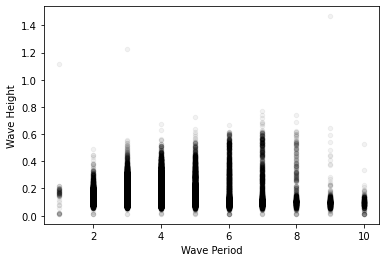

In [3]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)
# observation: non-linear relationship

In [4]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

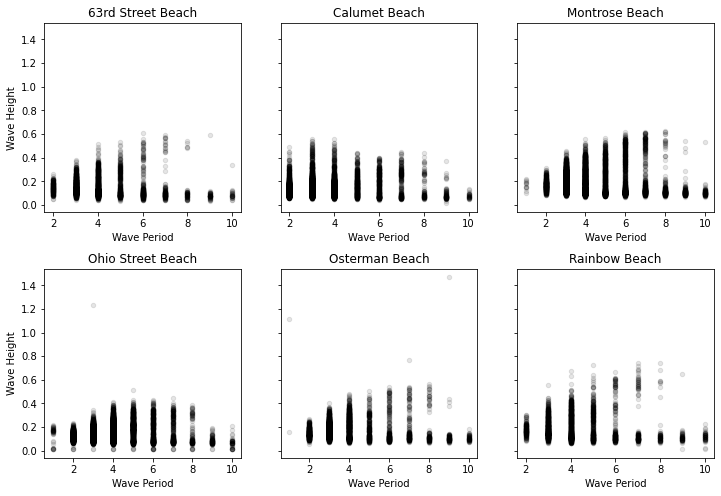

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)
# Obversation: beaches have distinct patterns (use OneHot encoding)

# Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer

In [7]:
train_df, test_df = train_test_split(df)
len(train_df), len(test_df)

(29037, 9679)

In [15]:
# linear on period
m1 = LinearRegression()
m1.fit(train_df[["Wave Period"]], train_df["Wave Height"])
print(m1.score(test_df[["Wave Period"]], test_df["Wave Height"]))
scores = cross_val_score(m1, train_df[["Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

-0.0008225306065605675


0.0017931748823582395

In [22]:
demo = train_df[["Wave Period"]].copy()
demo["period squared"] = demo["Wave Period"] ** 2
demo["period cubed"] = demo["Wave Period"] ** 3
demo

,Wave Period,period squared,period cubed
23350,2.0,4.0,8.0
23587,3.0,9.0,27.0
37238,5.0,25.0,125.0
11345,4.0,16.0,64.0
8348,2.0,4.0,8.0
...,...,...,...
12393,4.0,16.0,64.0
20775,3.0,9.0,27.0
25394,3.0,9.0,27.0
17241,4.0,16.0,64.0


In [30]:
poly = PolynomialFeatures(degree=4, include_bias=False)
data = poly.fit_transform(train_df[["Wave Period"]])
pd.DataFrame(data, columns=poly.get_feature_names(["period"]))

,period,period^2,period^3,period^4
0,2.0,4.0,8.0,16.0
1,3.0,9.0,27.0,81.0
2,5.0,25.0,125.0,625.0
3,4.0,16.0,64.0,256.0
4,2.0,4.0,8.0,16.0
...,...,...,...,...
29032,4.0,16.0,64.0,256.0
29033,3.0,9.0,27.0,81.0
29034,3.0,9.0,27.0,81.0
29035,4.0,16.0,64.0,256.0


In [33]:
# poly on period
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
m2.fit(train_df[["Wave Period"]], train_df["Wave Height"])
scores = cross_val_score(m2, train_df[["Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.0468138126176008

In [36]:
train_df[["Beach Name"]]

,Beach Name
23350,Ohio Street Beach
23587,Ohio Street Beach
37238,Ohio Street Beach
11345,Montrose Beach
8348,Calumet Beach
...,...
12393,Montrose Beach
20775,Ohio Street Beach
25394,Ohio Street Beach
17241,Montrose Beach


In [44]:
# linear on beach
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
scores = cross_val_score(m3, train_df[["Beach Name"]], train_df["Wave Height"], cv=10)
scores.mean()

0.055194979980017336

In [45]:
# regression on both beach AND poly of wave period
# linear on beach
m4 = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["Beach Name"]), 
                                     (PolynomialFeatures(degree=2, include_bias=False), ["Wave Period"]))),
    ("lr", LinearRegression())
])
scores = cross_val_score(m4, train_df[["Beach Name", "Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.09523314936918681

In [51]:
m4.fit(train_df[["Beach Name", "Wave Period"]], train_df["Wave Height"])
m4.score(test_df[["Beach Name", "Wave Period"]], test_df["Wave Height"])

0.08410361186638204